In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/guitarsounds')
%load_ext autoreload

In [3]:
%autoreload 2
from guitarsounds import Sound, Signal
import guitarsounds as guit

In [4]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, make_interp_spline

# Get a signal envelop

In [5]:
# Get a signal to test
sound = Sound('soundfiles/flax_carbon/Wood_D0_2.wav')
sound.condition()

TypeError: reduce_noise() got an unexpected keyword argument 'audio_clip'

In [6]:
help(reduce_noise)

Help on function reduce_noise in module noisereduce.noisereduce:

reduce_noise(y, sr, stationary=False, y_noise=None, prop_decrease=1.0, time_constant_s=2.0, freq_mask_smooth_hz=500, time_mask_smooth_ms=50, thresh_n_mult_nonstationary=2, sigmoid_slope_nonstationary=10, n_std_thresh_stationary=1.5, tmp_folder=None, chunk_size=600000, padding=30000, n_fft=1024, win_length=None, hop_length=None, clip_noise_stationary=True, use_tqdm=False, n_jobs=1)
    Reduce noise via spectral gating.
    
    Parameters
    ----------
    y : np.ndarray [shape=(# frames,) or (# channels, # frames)], real-valued
        input signal
    sr : int
        sample rate of input signal / noise signal
    y_noise : np.ndarray [shape=(# frames,) or (# channels, # frames)], real-valued
        noise signal to compute statistics over (only for non-stationary noise reduction).
    stationary : bool, optional
        Whether to perform stationary, or non-stationary noise reduction, by default False
    prop_decreas

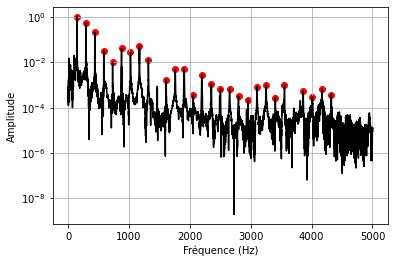

In [7]:
sound.SP.change('fft_range', 5000) # change the fft range so we get a lot of peaks
sound.signal.plot(kind='peaks')

In [8]:
# Calculer les pics
peaks = sound.signal.peaks()

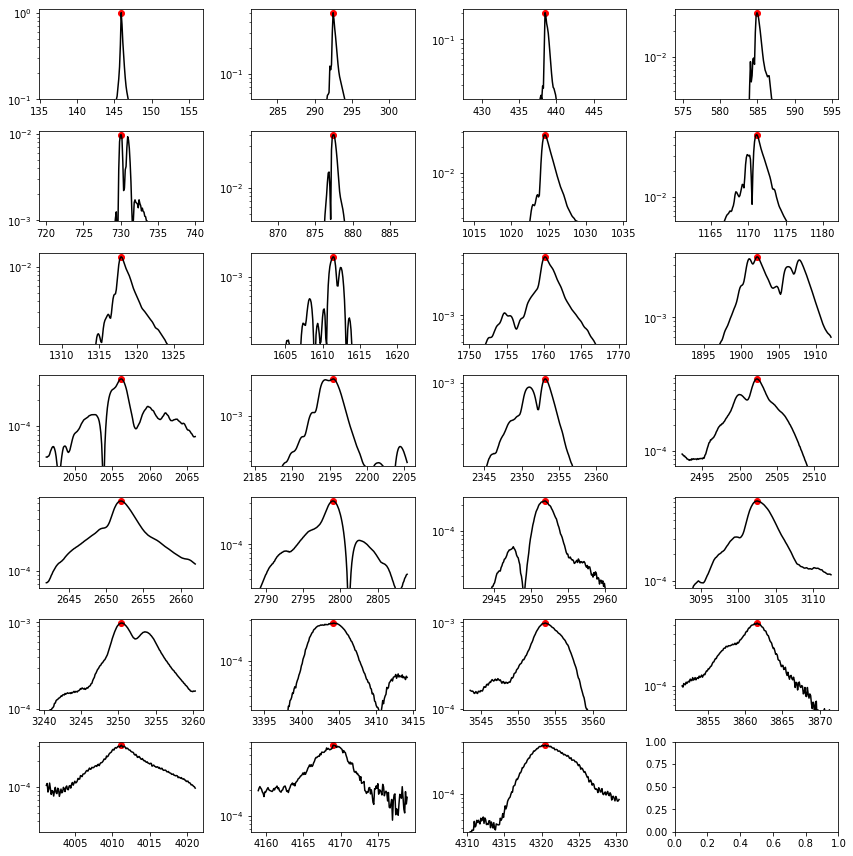

In [9]:
# Tracer chaque pic
fig, axs = plt.subplots(7,4, figsize=(12,12))
axs = axs.reshape(1, -1)[0]
for ax, peak in zip(axs,peaks):
    plt.sca(ax)
    freq = sound.signal.fft_frequencies()[peak]
    dist = np.where(sound.signal.fft_frequencies()>10)[0][0]
    height = sound.signal.fft()[peak]
    plt.plot(sound.signal.fft_frequencies()[peak-dist:peak+dist], sound.signal.fft()[peak-dist:peak+dist], c='k')
    plt.scatter(sound.signal.fft_frequencies()[peak], sound.signal.fft()[peak], c='r')
    plt.ylim((height/10, height*1.1))
    plt.yscale('log')
plt.tight_layout()

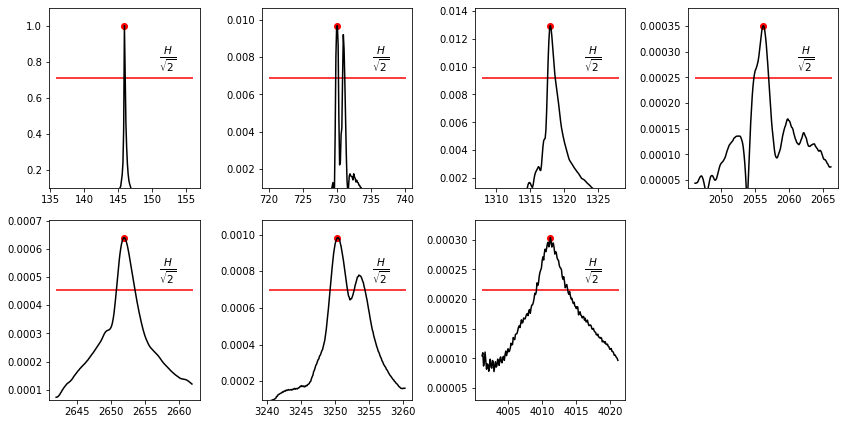

In [9]:
# Ajouter la valeur d'interception pour 7 pics 
indexes = np.arange(0, len(peaks), 4) # 1 pic sur 4
reduced_peaks = peaks[indexes]
fig, axs = plt.subplots(2,4, figsize=(12,6))
axs = axs.reshape(1, -1)[0]
for ax, peak in zip(axs,reduced_peaks):
    plt.sca(ax)
    freq = sound.signal.fft_frequencies()[peak]
    dist = np.where(sound.signal.fft_frequencies()>10)[0][0]
    height = sound.signal.fft()[peak]
    plt.plot(sound.signal.fft_frequencies()[peak-dist:peak+dist], sound.signal.fft()[peak-dist:peak+dist], c='k')
    plt.scatter(sound.signal.fft_frequencies()[peak], sound.signal.fft()[peak], c='r')
    plt.ylim((height/10, height*1.1))
    plt.hlines(height/np.sqrt(2), sound.signal.fft_frequencies()[peak-dist], sound.signal.fft_frequencies()[peak+dist], color='r')
    plt.annotate(r"$\frac{H}{\sqrt{2}}$", (sound.signal.fft_frequencies()[peak+dist//2], height/np.sqrt(2)+(height*1.1 - height/10)/10), fontsize=15)
plt.tight_layout()
axs[-1].set_axis_off()

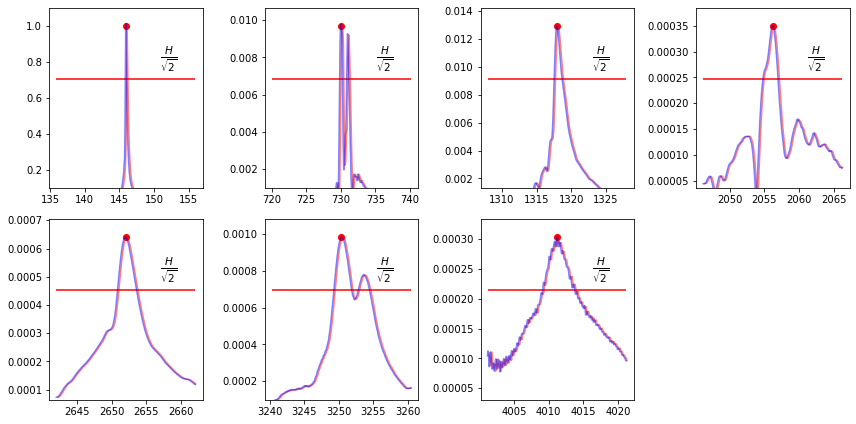

In [10]:
# Approximer chaque pic avec une spline univariante
indexes = np.arange(0, len(peaks), 4) # 1 pic sur 4
reduced_peaks = peaks[indexes]
fig, axs = plt.subplots(2,4, figsize=(12,6))
axs = axs.reshape(1, -1)[0]
fft = sound.signal.fft()[:len(sound.signal.fft())//2]
fft_freq = sound.signal.fft_frequencies()
signal_spline = InterpolatedUnivariateSpline(fft_freq, fft)

for ax, peak in zip(axs,reduced_peaks):
    plt.sca(ax)
    freq = fft_freq[peak]
    dist = np.where(fft_freq>10)[0][0]
    height = fft[peak]
    spline_freq = np.linspace(fft_freq[peak-dist], fft_freq[peak+dist], 1000)
    
    plt.plot(fft_freq[peak-dist:peak+dist]+0.2, fft[peak-dist:peak+dist], c='r', alpha=0.5)
    plt.plot(spline_freq, signal_spline(spline_freq), c='b', alpha=0.5)
    plt.scatter(fft_freq[peak], fft[peak], c='r')
    plt.ylim((height/10, height*1.1))
    plt.hlines(height/np.sqrt(2), fft_freq[peak-dist], fft_freq[peak+dist], color='r')
    annotation_height = height/np.sqrt(2)+(height*1.1 - height/10)/10
    plt.annotate(r"$\frac{H}{\sqrt{2}}$", (fft_freq[peak+dist//2], annotation_height), fontsize=15)

axs[-1].set_axis_off()
plt.tight_layout()

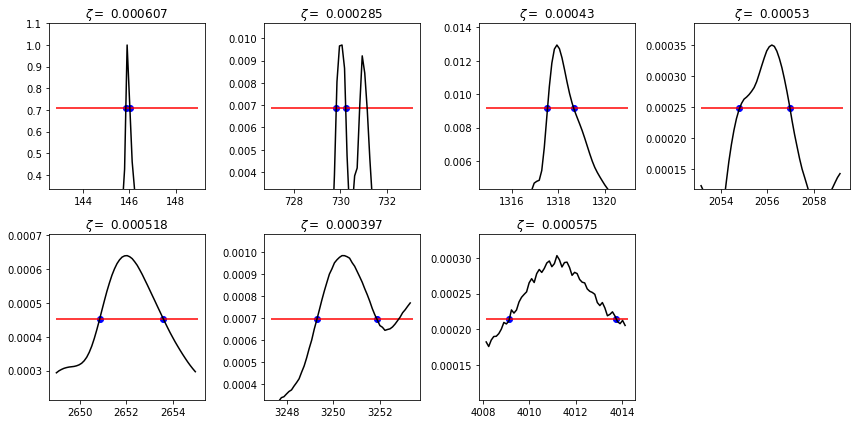

In [11]:
# Trouver les valeurs de w1 et w2 et de zeta

indexes = np.arange(0, len(peaks), 4) # 1 pic sur 4
reduced_peaks = peaks[indexes]
fig, axs = plt.subplots(2,4, figsize=(12,6))
axs = axs.reshape(1, -1)[0]
fft = sound.signal.fft()[:len(sound.signal.fft())//2]
fft_freq = sound.signal.fft_frequencies()


for ax, peak in zip(axs, reduced_peaks):
    plt.sca(ax)
    freq = fft_freq[peak]
    dist = np.where(fft_freq>3)[0][0]
    height = fft[peak]
    root_height = height/np.sqrt(2)
    frequency_roots = InterpolatedUnivariateSpline(fft_freq, fft-root_height).roots()
    sorted_indexes = np.argsort(np.abs(frequency_roots-freq))
    w2, w1 = frequency_roots[sorted_indexes[:2]]
    w1, w2 = np.sort([w1, w2])

    
    zeta = (w2 - w1)/(2*freq)
    
    plt.plot(fft_freq[peak-dist:peak+dist], fft[peak-dist:peak+dist], c='k')
    plt.scatter([w1, w2], [root_height, root_height], c='b')

    plt.ylim((height/3, height*1.1))
    plt.hlines(height/np.sqrt(2), fft_freq[peak-dist], fft_freq[peak+dist], color='r')
    plt.title(r"$\zeta =$ " + str(np.around(zeta, 6)))

axs[-1].set_axis_off()
plt.tight_layout()

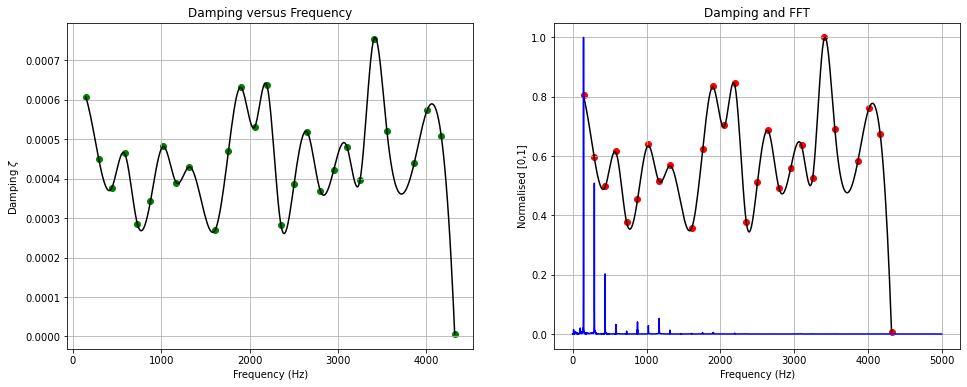

In [12]:
# Courbe damping-fréquence
fft = sound.signal.fft()[:len(sound.signal.fft())//2]
fft_freq = sound.signal.fft_frequencies()
peak_freqs = []
zetas = []

for peak in peaks:
    peak_frequency = fft_freq[peak]
    peak_height = fft[peak]
    root_height = peak_height/np.sqrt(2)
    frequency_roots = InterpolatedUnivariateSpline(fft_freq, fft-root_height).roots()
    sorted_roots_indexes = np.argsort(np.abs(frequency_roots-peak_frequency))
    w2, w1 = frequency_roots[sorted_roots_indexes[:2]]
    w1, w2 = np.sort([w1, w2])
    zeta = (w2 - w1)/(2*peak_frequency)
    zetas.append(zeta)
    peak_freqs.append(peak_frequency)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# First plot
ax1.scatter(peak_freqs, zetas, c='g')

frequencies = np.linspace(peak_freqs[0], peak_freqs[-1], 300)
spl = InterpolatedUnivariateSpline(peak_freqs, zetas, k=3)
ax1.plot(frequencies, spl(frequencies), c='k', label='spline')
ax1.grid('on')
ax1.set_title('Damping versus Frequency')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'Damping $\zeta$')

# Second plot
ax2.scatter(peak_freqs, np.array(zetas)*(1/np.array(zetas).max()), c='r')
normalised_damping = spl(frequencies)*1/spl(frequencies).max()
ax2.plot(frequencies, normalised_damping, c='k')
plt.sca(ax2)
sound.signal.plot('fft', c='b')
ax2.set_yscale('linear')
ax2.set_title('Damping and FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalised [0,1]')


plt.show()

## Implementation

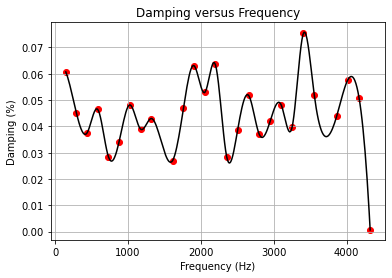

In [205]:
sound.signal.plot('damping')

## Testing

### 1. Working with different fundamentals

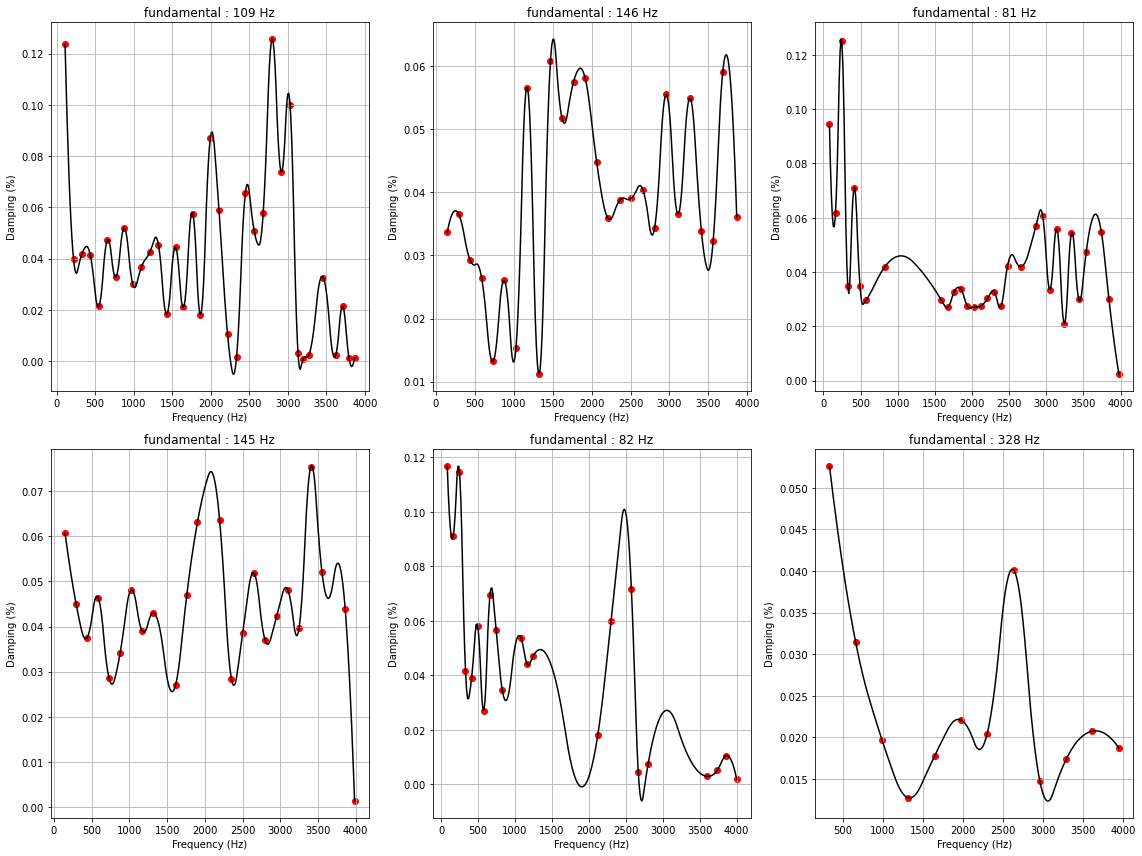

In [13]:
file1 = 'soundfiles/flax_carbon/Wood_A0_1.wav'
file2 = 'soundfiles/flax_carbon/Carbon_D0_2.wav'
file3 = 'soundfiles/flax_carbon/Carbon_E0_1.wav'
file4 = 'soundfiles/flax_carbon/Wood_D0_2.wav'
file5 = 'soundfiles/flax_carbon/Wood_E0_1.wav'
file6 = 'soundfiles/flax_carbon/Wood_E1_1.wav'
files = [file1, file2, file3, file4, file5, file6]

sounds = [Sound(file).condition(return_self=True) for file in files]

fig, axs = plt.subplots(2,3, figsize=(16,12))
axs = axs.reshape(1, -1)[0]

for sound, ax in zip(sounds, axs):
    sound.SP.change('fft_range', 4000)
    plt.sca(ax)
    sound.signal.plot('damping', c='k')
    ax.set_title('fundamental : ' + str(int(sound.signal.fundamental())) + ' Hz')
    
plt.tight_layout()

### 2. Comparing two materials

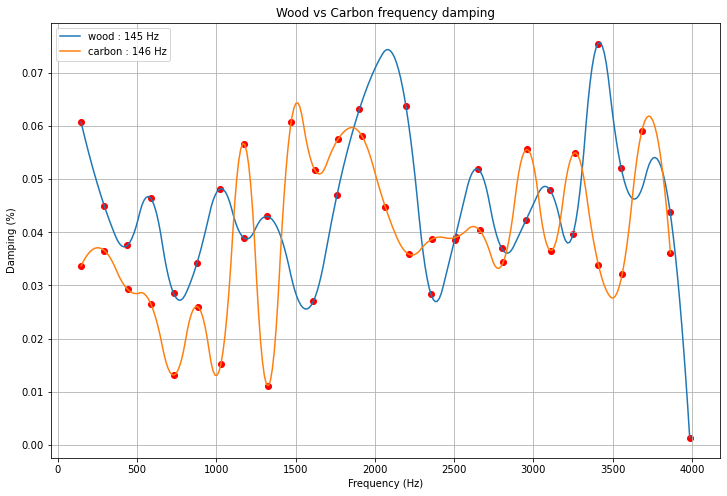

In [14]:
carbonfile = 'soundfiles/flax_carbon/Carbon_D0_2.wav'
woodfile = 'soundfiles/flax_carbon/Wood_D0_2.wav'

carbon = Sound(carbonfile, name='carbon').condition(return_self=True)
carbon.SP.change('fft_range', 4000)
wood = Sound(woodfile, name='wood').condition(return_self=True)
wood.SP.change('fft_range', 4000)

plt.figure(figsize=(12,8))
wood.signal.plot('damping', label = wood.name + ' : ' + str(int(wood.signal.fundamental())) + ' Hz')
carbon.signal.plot('damping', label = carbon.name + ' : ' + str(int(carbon.signal.fundamental())) + ' Hz')
plt.legend()
plt.title('Wood vs Carbon frequency damping')
plt.show()

### 3. Works for plates ?

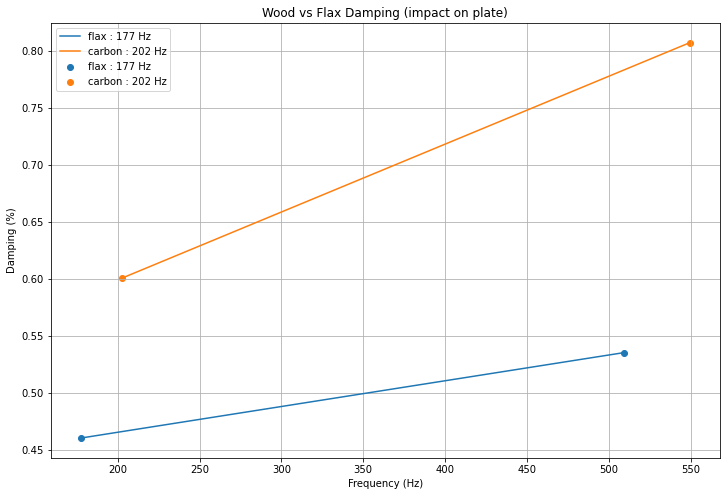

In [15]:
carbonfile = 'soundfiles/flax_carbon/Carbon.wav'
flaxfile = 'soundfiles/flax_carbon/Flax.wav'

carbon = Sound(carbonfile, name='carbon').condition(return_self=True)
carbon.SP.change('fft_range', 580)
flax = Sound(flaxfile, name='flax').condition(return_self=True)
flax.SP.change('fft_range', 580)

plt.figure(figsize=(12,8))
flax.signal.plot('damping', label = flax.name + ' : ' + str(int(flax.signal.fundamental())) + ' Hz')
carbon.signal.plot('damping', label = carbon.name + ' : ' + str(int(carbon.signal.fundamental())) + ' Hz')
plt.legend()
plt.title('Wood vs Flax Damping (impact on plate)')
plt.show()